# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

---
## 2. Load data

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/BCG DS/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [4]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [6]:
price_df = pd.read_csv('/content/drive/MyDrive/BCG DS/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Now it is time to get creative and to conduct some of your own feature engineering! Have fun with it, explore different ideas and try to create as many as yo can!

In [8]:
# Ensure date column is datetime
price_df['price_date'] = pd.to_datetime(price_df['price_date'])
price_df['month'] = price_df['price_date'].dt.month
price_df['year'] = price_df['price_date'].dt.year
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


# Average Price Range (Across Periods) per consumer

In [9]:
# Aggregate average prices per period by company
avg_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [10]:
# Calculate the avg difference between consecutive periods
avg_prices['off_peak_peak_var_avg_diff'] = avg_prices['price_off_peak_var'] - avg_prices['price_peak_var']
avg_prices['peak_mid_peak_var_avg_diff'] = avg_prices['price_peak_var'] - avg_prices['price_mid_peak_var']
avg_prices['off_peak_mid_peak_var_avg_diff'] = avg_prices['price_off_peak_var'] - avg_prices['price_mid_peak_var']
avg_prices['off_peak_peak_fix_avg_diff'] = avg_prices['price_off_peak_fix'] - avg_prices['price_peak_fix']
avg_prices['peak_mid_peak_fix_avg_diff'] = avg_prices['price_peak_fix'] - avg_prices['price_mid_peak_fix']
avg_prices['off_peak_mid_peak_fix_avg_diff'] = avg_prices['price_off_peak_fix'] - avg_prices['price_mid_peak_fix']

columns = [
    'id',
    'off_peak_peak_var_avg_diff',
    'peak_mid_peak_var_avg_diff',
    'off_peak_mid_peak_var_avg_diff',
    'off_peak_peak_fix_avg_diff',
    'peak_mid_peak_fix_avg_diff',
    'off_peak_mid_peak_fix_avg_diff'
]
df = pd.merge(df, avg_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_avg_diff,peak_mid_peak_var_avg_diff,off_peak_mid_peak_var_avg_diff,off_peak_peak_fix_avg_diff,peak_mid_peak_fix_avg_diff,off_peak_mid_peak_fix_avg_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


For each customer, these show how much their price varied across periods (peak, mid-peak, off-peak), averaged across all months.

# 2. Price Volatility Across Months

In [11]:
# Aggregate average prices per period by company
avg_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

# Calculate the avg difference between consecutive periods
avg_prices_by_month['off_peak_peak_var_avg_diff'] = avg_prices_by_month['price_off_peak_var'] - avg_prices_by_month['price_peak_var']
avg_prices_by_month['peak_mid_peak_var_avg_diff'] = avg_prices_by_month['price_peak_var'] - avg_prices_by_month['price_mid_peak_var']
avg_prices_by_month['off_peak_mid_peak_var_avg_diff'] = avg_prices_by_month['price_off_peak_var'] - avg_prices_by_month['price_mid_peak_var']
avg_prices_by_month['off_peak_peak_fix_avg_diff'] = avg_prices_by_month['price_off_peak_fix'] - avg_prices_by_month['price_peak_fix']
avg_prices_by_month['peak_mid_peak_fix_avg_diff'] = avg_prices_by_month['price_peak_fix'] - avg_prices_by_month['price_mid_peak_fix']
avg_prices_by_month['off_peak_mid_peak_fix_avg_diff'] = avg_prices_by_month['price_off_peak_fix'] - avg_prices_by_month['price_mid_peak_fix']

# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = avg_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_avg_diff': 'max',
    'peak_mid_peak_var_avg_diff': 'max',
    'off_peak_mid_peak_var_avg_diff': 'max',
    'off_peak_peak_fix_avg_diff': 'max',
    'peak_mid_peak_fix_avg_diff': 'max',
    'off_peak_mid_peak_fix_avg_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_avg_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_avg_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_avg_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_avg_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_avg_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_avg_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_avg_diff,off_peak_peak_fix_avg_diff,peak_mid_peak_fix_avg_diff,off_peak_mid_peak_fix_avg_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


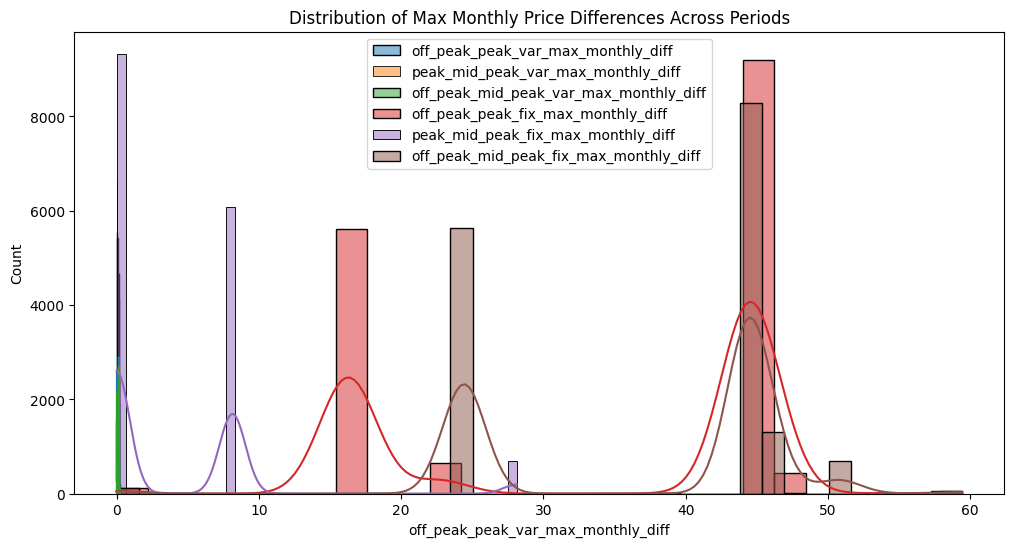

In [12]:
plt.figure(figsize=(12, 6))
for col in max_diff_across_periods_months.columns[1:]:
    sns.histplot(max_diff_across_periods_months[col], kde=True, label=col, alpha=0.5)
plt.legend()
plt.title("Distribution of Max Monthly Price Differences Across Periods")
plt.show()


# Insights from the Distributions
The bulk of the data is clustered around zero for most features (many customers don’t see big changes in monthly price differences).

Some features like off_peak_peak_fix_max_monthly_diff and off_peak_mid_peak_fix_max_monthly_diff show pronounced peaks at higher values (e.g., ~40-50) — these represent customers who experienced substantial price changes.

This variability and peak structure suggest that for some customers, price volatility is significant — and this might be a strong predictor of churn.

In [13]:
# Contract length in days and years
df['date_activ'] = pd.to_datetime(df['date_activ'], errors='coerce')
df['date_end'] = pd.to_datetime(df['date_end'], errors='coerce')
df['contract_length_days'] = (df['date_end'] - df['date_activ']).dt.days
df['contract_length_years'] = df['contract_length_days'] / 365

# Time to renewal in days
df['date_renewal'] = pd.to_datetime(df['date_renewal'], errors='coerce')
today = pd.to_datetime('today')
df['days_to_renewal'] = (df['date_renewal'] - today).dt.days


df.groupby(['contract_length_years']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
contract_length_years,
11.994521,1.0
11.424658,1.0
11.512329,1.0
10.068493,1.0
9.134247,1.0
...,...
5.136986,0.0
5.139726,0.0
5.142466,0.0


# Extract Month Columns and Drop Raw Dates


In [14]:
# Extract month from dates
df['activation_month'] = df['date_activ'].dt.month
df['end_month'] = df['date_end'].dt.month
df['renewal_month'] = df['date_renewal'].dt.month
df['months_modif_prod'] = df['date_modif_prod'].dt.month

# Drop raw date columns
df = df.drop(columns=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])


# BINARY FEATURES

In [15]:
# Has gas: convert to binary
df['has_gas'] = df['has_gas'].map({'t': 1, 'f': 0})


# Log-Transform Skewed Features

In [16]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

<ipython-input-17-f63759cfd0e3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-17-f63759cfd0e3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-17-f63759cfd0e3>:5: U

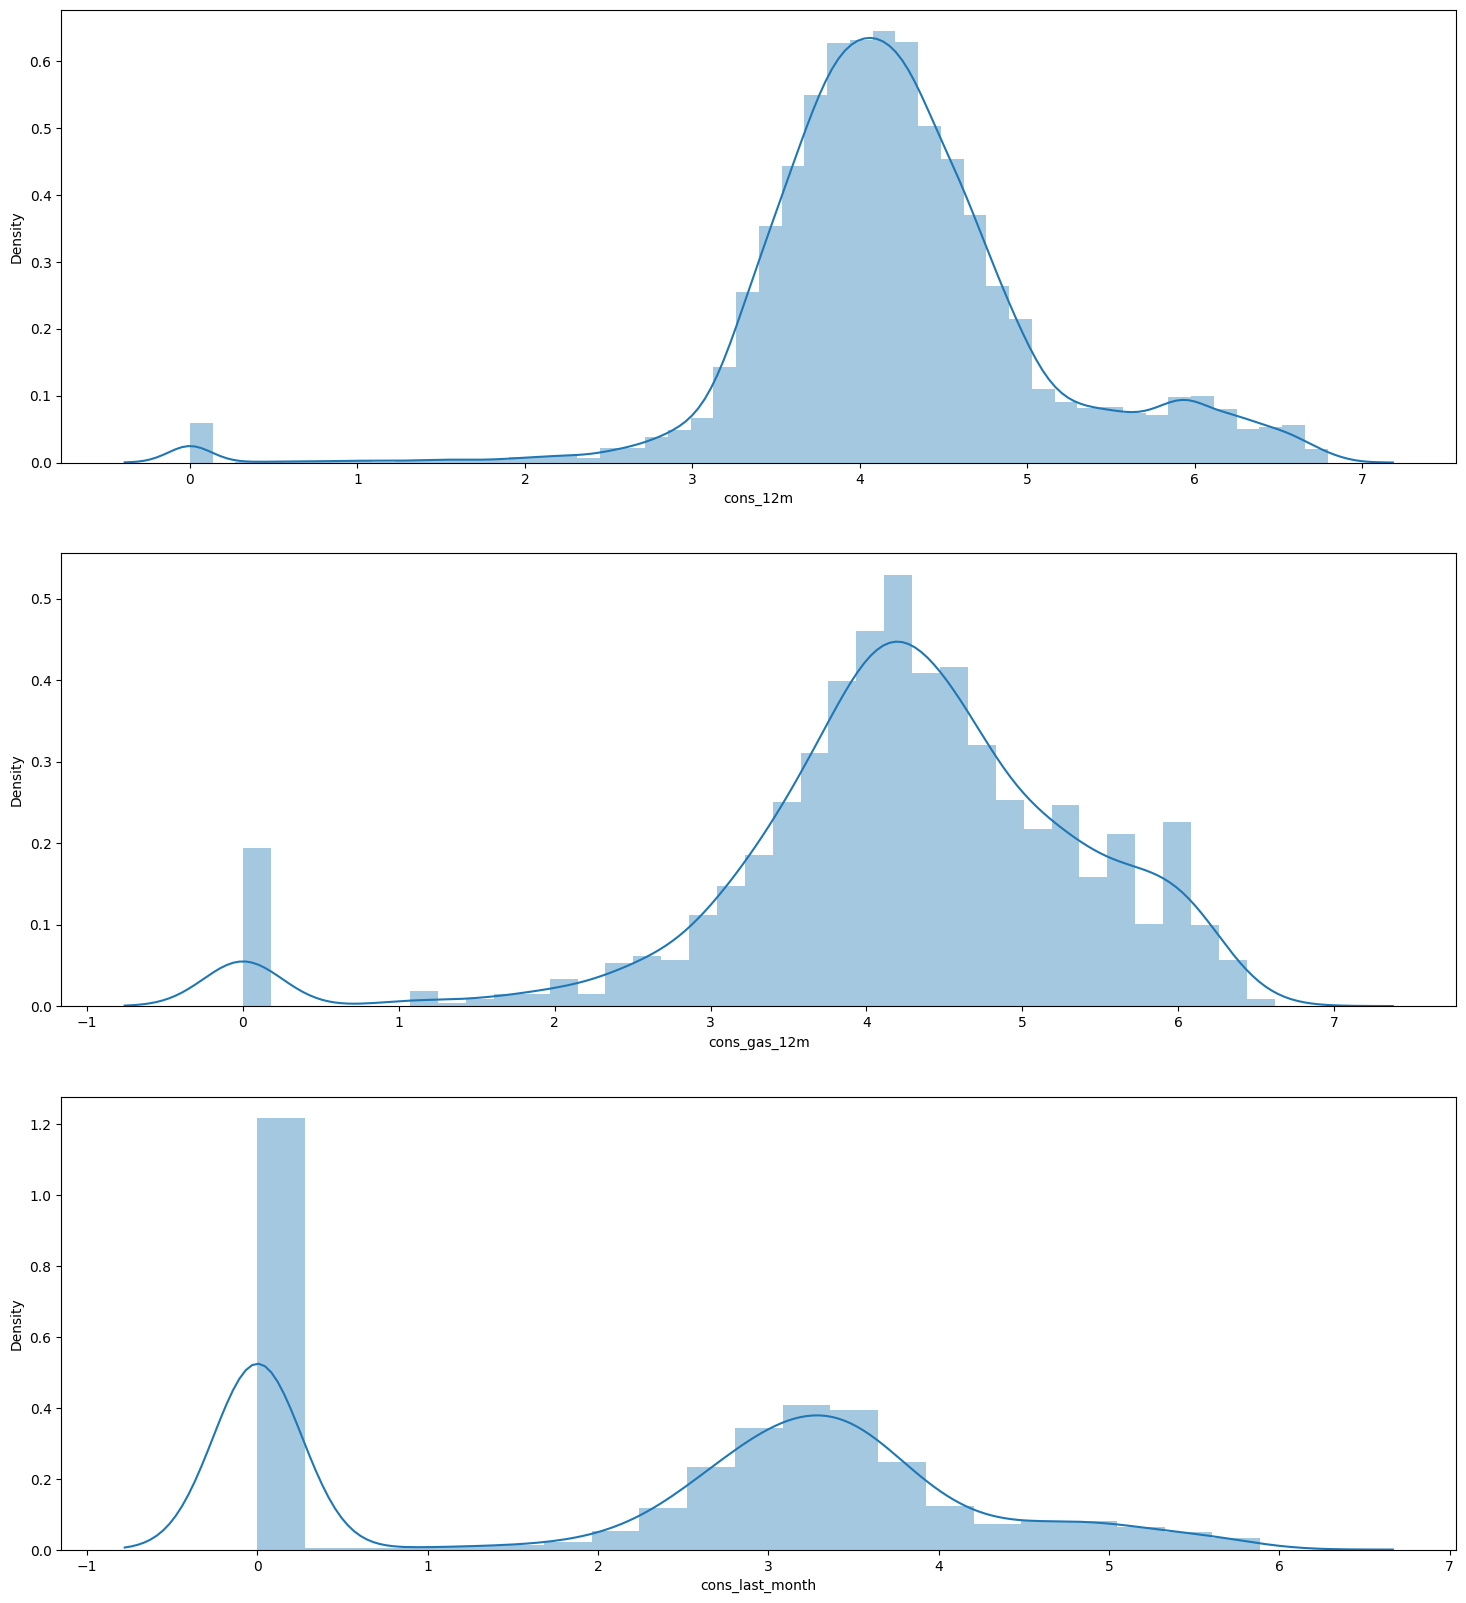

In [17]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

# Encoding
In this step we apply encoding to our categorical columns before applying the ml model.We will drop features with little to no data as either way they will be at the bottom of the graph in feature importance

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      14606 non-null  object 
 1   channel_sales                           14606 non-null  object 
 2   cons_12m                                14606 non-null  float64
 3   cons_gas_12m                            14606 non-null  float64
 4   cons_last_month                         14606 non-null  float64
 5   forecast_cons_12m                       14606 non-null  float64
 6   forecast_cons_year                      14606 non-null  float64
 7   forecast_discount_energy                14606 non-null  float64
 8   forecast_meter_rent_12m                 14606 non-null  float64
 9   forecast_price_energy_off_peak          14606 non-null  float64
 10  forecast_price_energy_peak              14606 non-null  fl

In [19]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

,count
channel_sales,
foosdfpfkusacimwkcsosbicdxkicaua,6754
MISSING,3725
lmkebamcaaclubfxadlmueccxoimlema,1843
usilxuppasemubllopkaafesmlibmsdf,1375
ewpakwlliwisiwduibdlfmalxowmwpci,893
sddiedcslfslkckwlfkdpoeeailfpeds,11
epumfxlbckeskwekxbiuasklxalciiuu,3
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [20]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,days_to_renewal,activation_month,end_month,renewal_month,months_modif_prod,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,-3639,6,6,6,11,False,False,True,False,False
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,0.000000,...,-3570,8,8,8,8,True,False,False,False,False
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,0.087899,...,-3706,4,4,4,4,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,0.000000,...,-3723,3,3,3,3,False,False,False,True,False
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.116900,0.100015,...,-3745,1,3,3,1,True,False,False,False,False


In [21]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

,count
origin_up,
lxidpiddsbxsbosboudacockeimpuepw,7097
kamkkxfxxuwbdslkwifmmcsiusiuosws,4294
ldkssxwpmemidmecebumciepifcamkci,3148
MISSING,64
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [22]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,renewal_month,months_modif_prod,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,6,11,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,0.000000,...,8,8,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,0.087899,...,4,4,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,0.000000,...,3,3,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.116900,0.100015,...,3,1,True,False,False,False,False,True,False,False


# Correlation

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_cons_year                          14606 non-null  float64
 6   forecast_discount_energy                    14606 non-null  float64
 7   forecast_meter_rent_12m                     14606 non-null  float64
 8   forecast_price_energy_off_peak              14606 non-null  float64
 9   forecast_price_energy_peak                  14606 non-null  float64
 10  forecast_p

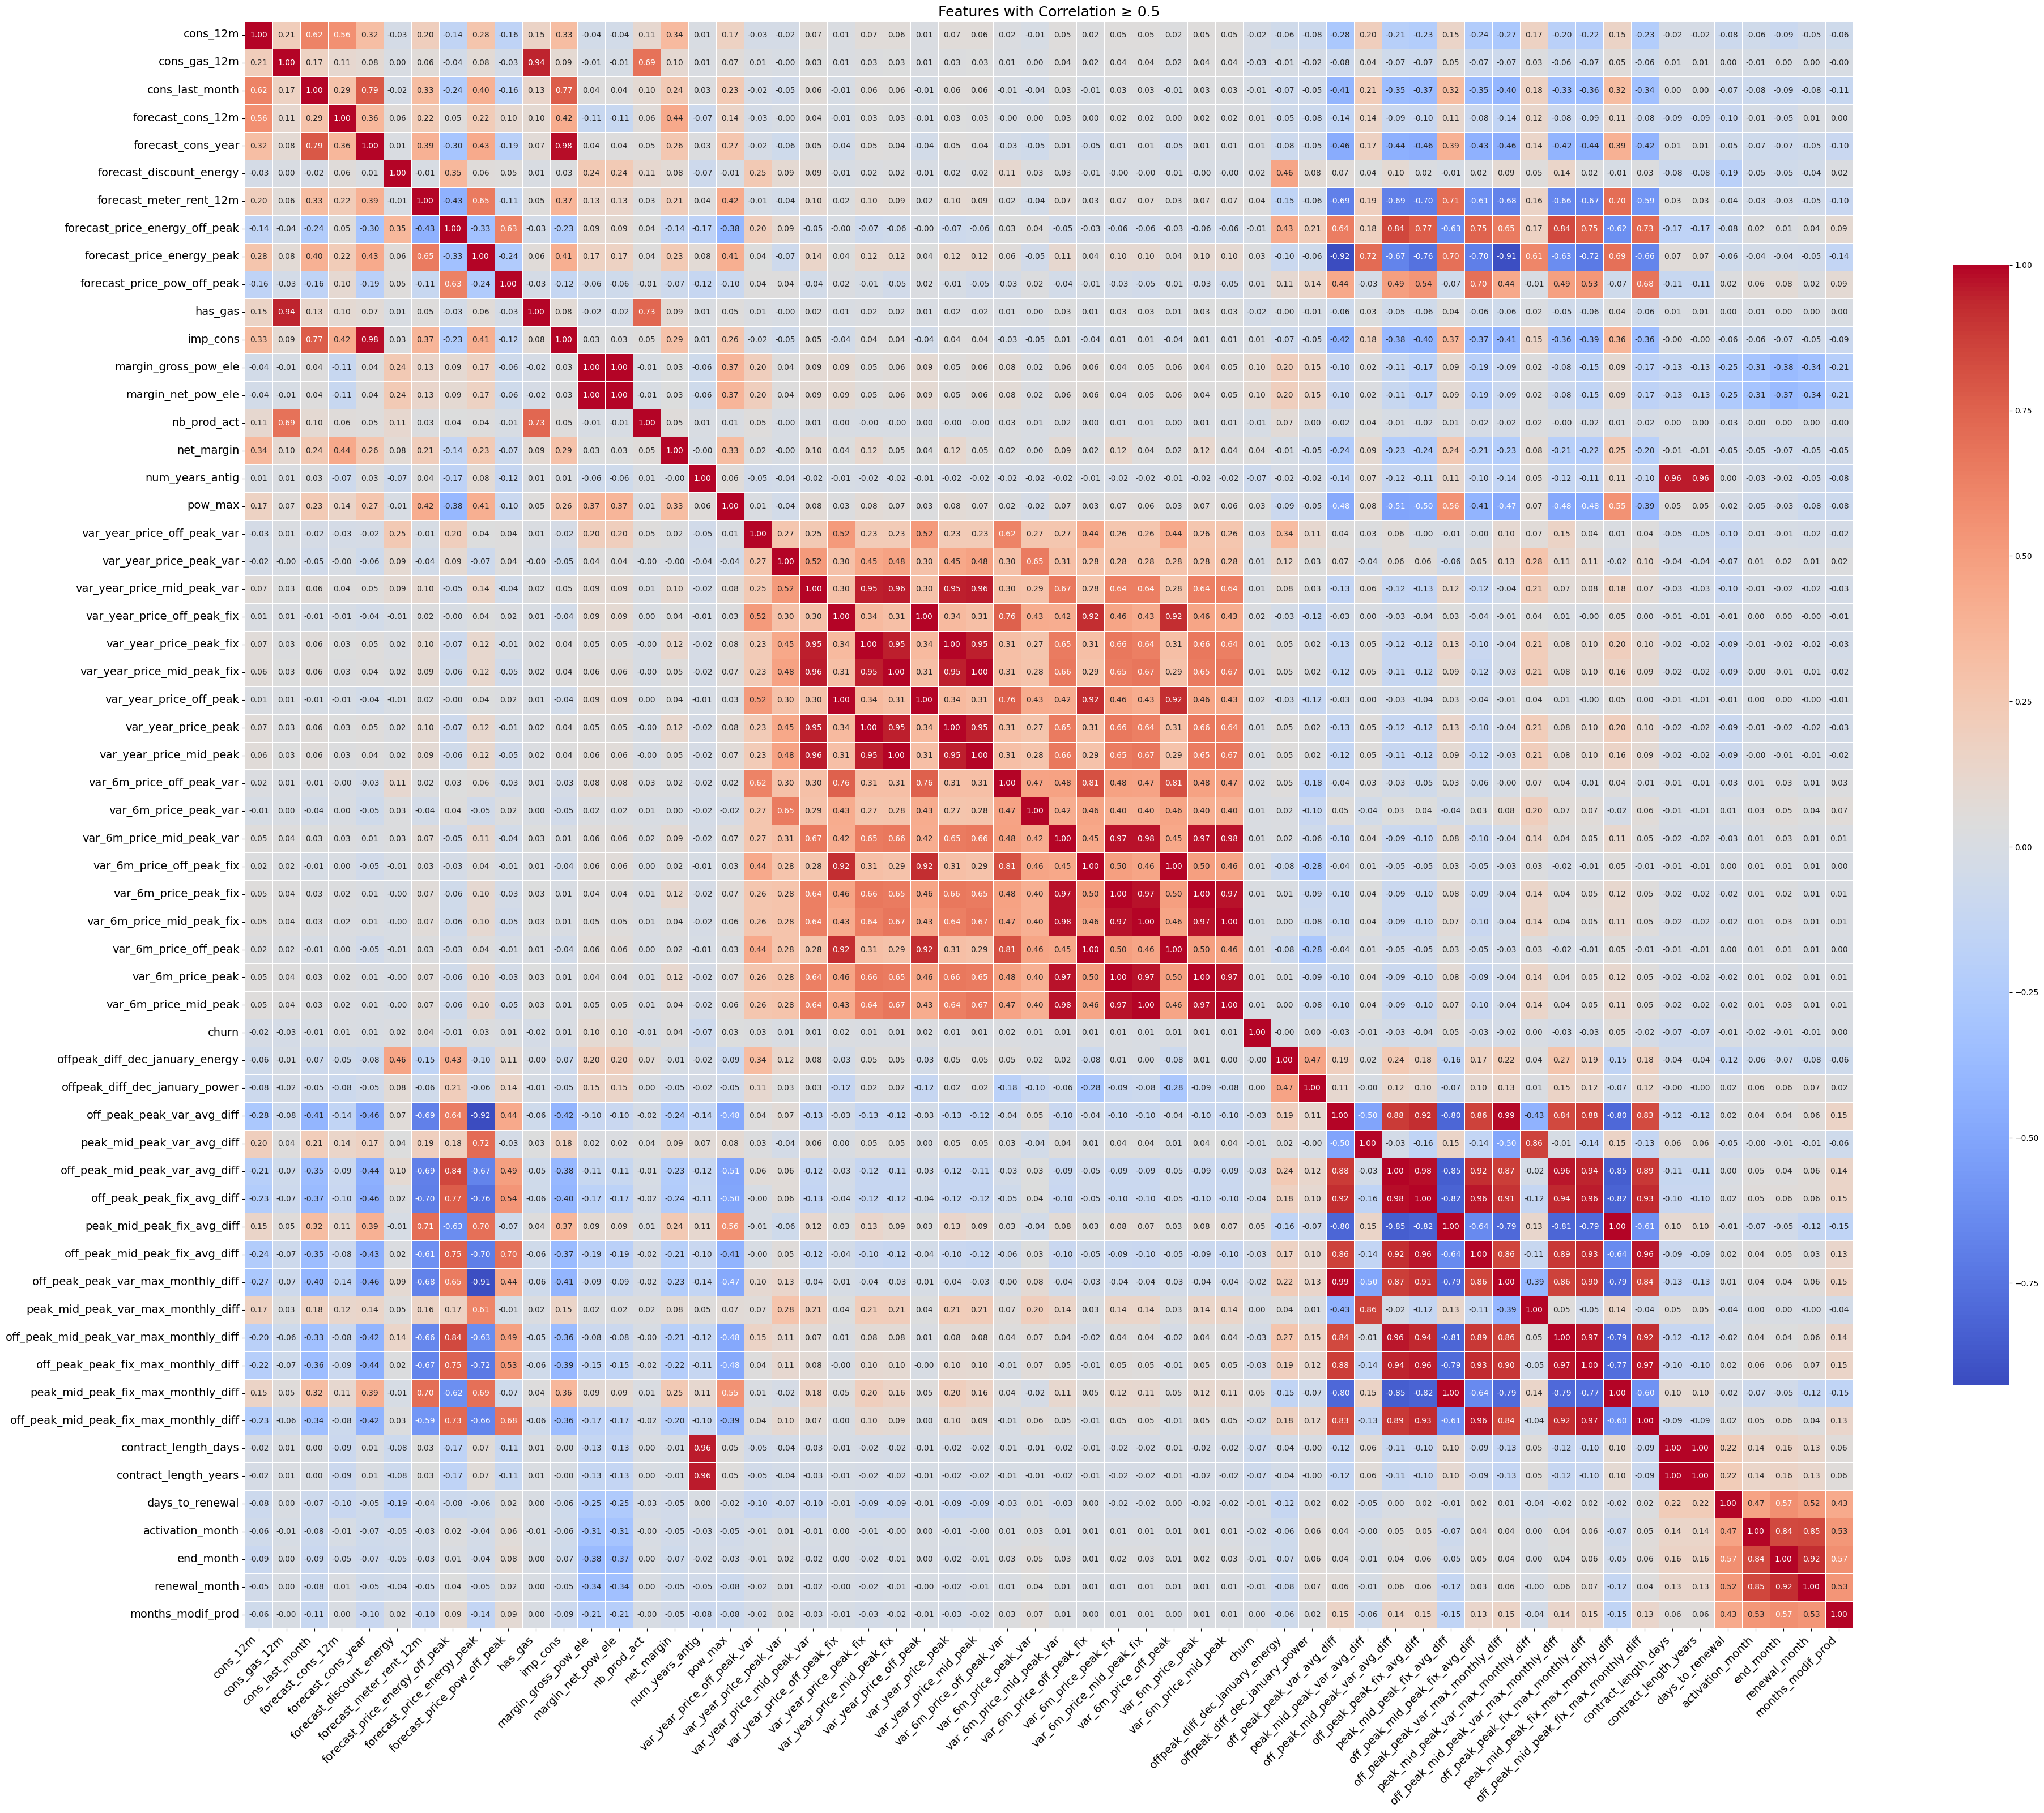

In [24]:
numeric_df = df.select_dtypes(include=np.number)
correlation = numeric_df.corr()
high_corr = correlation.loc[(correlation.abs() >= 0.5).any(axis=1), (correlation.abs() >= 0.5).any(axis=0)]
plt.figure(figsize=(40, 40))

sns.heatmap(
    high_corr,
    annot=True,  # Show correlation values
    fmt=".2f",   # Format the numbers to 2 decimal places
    cmap="coolwarm",
    square=True,
    cbar_kws={'shrink': 0.5},
    linewidths=0.5
)

# Increase font size for axis labels
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14, rotation=0)

plt.title("Features with Correlation ≥ 0.5", fontsize=18)
plt.tight_layout()
plt.show()


In [27]:
# List of features to drop (redundant or highly correlated)
drop_cols = [
    'cons_gas_12m',
    'cons_last_month',
    'imp_cons',
    'forecast_cons_year',      # keep forecast_cons_12m
    'contract_length_days',
    'margin_gross_pow_ele',
    'has_gas',
    'end_month',
    'activation_month',
    'renewal_month',
    'num_years_antig',
    'forecast_cons_year',
    'cons_12m',
    'net_margin',
     'var_year_price_off_peak_var',
 'off_peak_peak_var_avg_diff',
 'off_peak_mid_peak_var_avg_diff',
 'off_peak_peak_fix_avg_diff',
 'off_peak_peak_var_max_monthly_diff',
 'off_peak_mid_peak_fix_max_monthly_diff'
]

df.drop(columns=drop_cols, inplace=True, errors='ignore')

print("Dropped columns:", drop_cols)


Dropped columns: ['cons_gas_12m', 'cons_last_month', 'imp_cons', 'forecast_cons_year', 'contract_length_days', 'margin_gross_pow_ele', 'has_gas', 'end_month', 'activation_month', 'renewal_month', 'num_years_antig', 'forecast_cons_year', 'cons_12m', 'net_margin', 'var_year_price_off_peak_var', 'off_peak_peak_var_avg_diff', 'off_peak_mid_peak_var_avg_diff', 'off_peak_peak_fix_avg_diff', 'off_peak_peak_var_max_monthly_diff', 'off_peak_mid_peak_fix_max_monthly_diff']


In [28]:
# Identify columns to drop
cols_to_drop = [col for col in df.columns if col.startswith('var')]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"Dropped columns: {cols_to_drop}")


Dropped columns: []
